# COVID-19 Visualisation Plots

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from matplotlib import pyplot
import time
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from datetime import date
import matplotlib.patches as mpatches
import os

In [2]:
def plot_time_pred(true, predict,cases_type,country,arg):
    
    plt.subplot(arg)
    
    markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
    colors = ['r','g','b','c','m', 'y', 'k','orange','white']
    
    plt.plot(true, label = 'True',marker= markers[2] , color=colors[1], linewidth=3.0,ms=10)
    plt.plot(predict['Predicted'], marker= markers[4] , color=colors[4] , label = 'Predicted', linewidth=3.0,ms=12)

    plt.xlabel('Dates', size=17)
    plt.ylabel(cases_type + ' Cases', size=17)
    
    if (cases_type == 'Confirmed'):
        low_95 = 'low95' + 'N'
        high95 = 'high95' + 'N'
    elif (cases_type == 'Death'):
        low_95 = 'low95' + 'D'
        high95 = 'high95' + 'D'
    
    plt.subplots_adjust(hspace=0.4,top=0.95)
    
    
    country_patch = mpatches.Patch(color= colors[8], label = country)

    country_legend = plt.legend(handles=[country_patch],loc = 'lower right',prop={'size': 17})
    plt.gca().add_artist(country_legend)
    
    plt.legend(loc = 'upper left',prop={'size': 17})

    
    plt.fill_between(predict.index,predict[low_95],  predict[high95], color='red', alpha=.3) 
    
    plt.xticks(rotation='vertical',size=17)
    plt.yticks(size=17)


In [3]:
def Visualize_Cases(pred_days_ahead,cases_type,country,arg):
    data_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
    
    if (cases_type == 'Confirmed'):
        input_data = 'time_series_covid19_confirmed_global.csv'
    elif (cases_type == 'Death'):
        input_data = 'time_series_covid19_deaths_global.csv'
        
    cases = pd.read_csv(data_path + input_data)

    drop_columns = ['Lat','Long']
    cases.drop(drop_columns, inplace=True, axis=1)
    
    colnames = cases.columns.values
    
    region = cases.loc[cases['Country/Region'] == country]
    region =  np.array(region.loc[:, colnames[4]:colnames[-1]])
    
    date_rng = pd.date_range(start=colnames[4], end=colnames[-1], freq='D') #creates the days
    df_true = pd.DataFrame(date_rng, columns=['date'])
    df_true['True']=np.transpose(region) #this is a dataframe with dates and cases.
    df_true = df_true.set_index('date')
    
    path = '../Predictions/'+str(pred_days_ahead)+'day_prediction/TOTAL/'
    prediction_files = os.listdir(path)
    
    # Read predictions from days ahead and extract the predictions in predictions df 
    i = 0
    predictions = pd.DataFrame()
    for file in prediction_files:

        i = i+1
        pred = pd.read_csv(path + file)
        pred = pred.loc[pred['Country'] == country]

        if (cases_type == 'Confirmed'):
            drop_columns = ['Province/State','Country',
              'R','low95R','high95R','D','low95D','high95D','T','low95T','high95T',
               'M','low95M','high95M','C','low95C','high95C']
        elif (cases_type == 'Death'):
             drop_columns = ['Province/State','Country',
              'N','low95N','high95N','R','low95R','high95R','T','low95T','high95T',
               'M','low95M','high95M','C','low95C','high95C']

        pred.drop(drop_columns, inplace=True, axis=1)

        if (i == 1):
            header = True
        else:
            header = False

        predictions = predictions.append(pred)

    if (cases_type == 'Confirmed'):
        predictions.rename(columns={'Target/Date':'date','N': 'Predicted'}, inplace=True)
    elif (cases_type == 'Death'):
        predictions.rename(columns={'Target/Date':'date','D': 'Predicted'}, inplace=True)
    predictions.set_index('date', inplace=True)
    predictions.index = pd.to_datetime(predictions.index)
    predictions = predictions.sort_values('date', ascending=True)
    
    plot_time_pred(df_true[-24:len(df_true)], predictions,cases_type,country,arg)
    

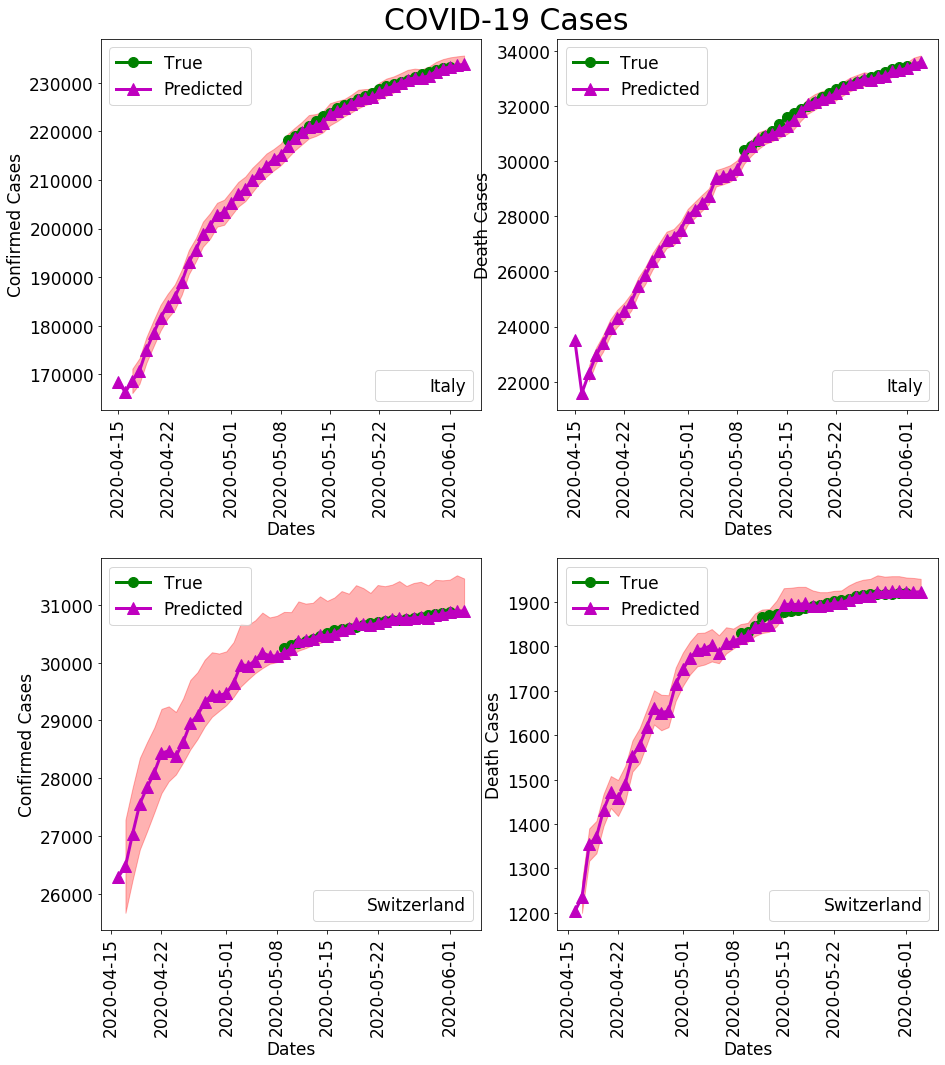

In [4]:
pred_days_ahead = 2
fig = plt.figure(figsize=(15, 15))
fig.suptitle('COVID-19 Cases', size=30)
Visualize_Cases(pred_days_ahead,'Confirmed','Italy',221)
Visualize_Cases(pred_days_ahead,'Death','Italy',222)
Visualize_Cases(pred_days_ahead,'Confirmed','Switzerland',223)
Visualize_Cases(pred_days_ahead,'Death','Switzerland',224)

plt.show()
fig.savefig('Predictions.pdf', bbox_inches='tight')        